In [5]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as denset_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobile_preprocess
from tensorflow.keras import applications
from tensorflow.keras import optimizers
import numpy as np
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, LambdaCallback, ModelCheckpoint, LearningRateScheduler
import cv2
from sklearn.metrics import classification_report, confusion_matrix


In [6]:

def estimate(X_train, y_train, back_bone):
    IMAGE_WIDTH = 224                               # Image width
    IMAGE_HEIGHT = 224                              # Image height
    input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)    # (width, height, channel) channel = 3 ---> RGB
    batch_size = 8                                  # Batch size 
    epochs = 40                                     # Number of epochs
    ntrain = 0.8 * len(X_train)                     # Split data with 80/20 train/validation
    nval = 0.2 * len(X_train)
    back_bone = str(back_bone)
    X = []
    X_train = np.reshape(np.array(X_train), [len(X_train), ])

    for img in list(range(0, len(X_train))):

        if X_train[img].ndim >= 3:
            X.append(cv2.resize(
                X_train[img][:, :, :3], (IMAGE_WIDTH, IMAGE_HEIGHT), interpolation=cv2.INTER_CUBIC))
        else:
            smimg = cv2.cvtColor(X_train[img][0], cv2.COLOR_GRAY2RGB)
            X.append(cv2.resize(smimg, (IMAGE_WIDTH, IMAGE_HEIGHT),
                                interpolation=cv2.INTER_CUBIC))

        if y_train[img] == 'COVID':
            y_train[img] = 1
        elif y_train[img] == 'NonCOVID':
            y_train[img] = 0
        else:
            continue

    x = np.array(X)
    X_train, X_val, y_train, y_val = train_test_split(          # 20% validation set
        x, y_train, test_size=0.20, random_state=2)

    # data generator
    if back_bone == 'ResNet50V2':
        train_datagen = ImageDataGenerator(
            preprocessing_function=resnet_preprocess,
            rotation_range=15,
            shear_range=0.1,
            zoom_range=0.2,
            horizontal_flip=True,
            width_shift_range=0.1,
            height_shift_range=0.1
        )

        val_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)

    elif back_bone == 'Xception':
        train_datagen = ImageDataGenerator(
            preprocessing_function=xception_preprocess,
            rotation_range=15,
            shear_range=0.1,
            zoom_range=0.2,
            horizontal_flip=True,
            width_shift_range=0.1,
            height_shift_range=0.1
        )

        val_datagen = ImageDataGenerator(preprocessing_function=xception_preprocess)
    elif back_bone == "DenseNet201":
        train_datagen = ImageDataGenerator(
            preprocessing_function=denset_preprocess,
            rotation_range=15,
            shear_range=0.1,
            zoom_range=0.2,
            horizontal_flip=True,
            width_shift_range=0.1,
            height_shift_range=0.1
        )

        val_datagen = ImageDataGenerator(preprocessing_function=denset_preprocess)
    elif back_bone == "MobileNetV2":
        train_datagen = ImageDataGenerator(
            preprocessing_function= mobile_preprocess,
            rotation_range=15,
            shear_range=0.1,
            zoom_range=0.2,
            horizontal_flip=True,
            width_shift_range=0.1,
            height_shift_range=0.1
        )

        val_datagen = ImageDataGenerator(preprocessing_function=mobile_preprocess)
    else:
        raise ValueError('Please select transfer learning model!')
    train_generator = train_datagen.flow(
        X_train, y_train, batch_size=batch_size, shuffle=True)
    val_generator = val_datagen.flow(
        X_val, y_val, batch_size=batch_size, shuffle=True)

    # model
    model = Sequential()
    if back_bone == 'ResNet50V2':
        base_model = applications.resnet_v2.ResNet50V2(
            include_top=False, pooling='avg', weights='imagenet', input_shape=input_shape)
    elif back_bone == 'Xception':
        base_model = applications.Xception(
            include_top=False, pooling='avg', weights='imagenet', input_shape=input_shape)
    elif back_bone == 'DenseNet201':
        base_model = applications.DenseNet201(
            include_top=False, pooling='avg', weights='imagenet', input_shape=input_shape)
    elif back_bone == 'MobileNetV2':
        base_model = applications.MobileNetV2(
            include_top=False, pooling='avg', weights='imagenet', input_shape=input_shape)
    else:
        raise ValueError('Please select transfer learning model!')

    base_model.trainable = False

    model.add(base_model)

    model.add(BatchNormalization())
    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(lr=1e-4),
                  metrics=['acc'])

    # callbacks
    lr_reducer = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.8,
        patience=5,
        verbose=1,
        mode='auto',
        min_delta=0.0001,
        cooldown=3,
        min_lr=1e-14)

    best_loss_path = "Model.h5"
    ck_loss_model = ModelCheckpoint(
        best_loss_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    callbacks = [ck_loss_model, lr_reducer]

    history = model.fit_generator(train_generator,
                                  steps_per_epoch=ntrain//batch_size,
                                  epochs=epochs,
                                  validation_data=val_generator,
                                  validation_steps=nval // batch_size,
                                  callbacks=callbacks)

    return model


def predict(X_test, model, back_bone):
    i = 0
    nrows = 224
    ncolumns = 224
    channels = 1
    back_bone = str(back_bone)
    X = []
    X_test = np.reshape(np.array(X_test), [len(X_test), ])

    for img in list(range(0, len(X_test))):

        if X_test[img].ndim >= 3:
            X.append(cv2.resize(
                X_test[img][:, :, :3], (nrows, ncolumns), interpolation=cv2.INTER_CUBIC))
        else:
            smimg = cv2.cvtColor(X_test[img][0], cv2.COLOR_GRAY2RGB)
            X.append(cv2.resize(smimg, (nrows, ncolumns),
                                interpolation=cv2.INTER_CUBIC))

    x = np.array(X)

    y_pred = []
    if back_bone == 'ResNet50V2':
        test_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)
    elif back_bone == 'Xception':
        test_datagen = ImageDataGenerator(preprocessing_function=xception_preprocess)
    elif back_bone == 'DenseNet201':
        test_datagen = ImageDataGenerator(preprocessing_function=denset_preprocess)
    elif back_bone == 'MobileNetV2':
        test_datagen = ImageDataGenerator(preprocessing_function=mobile_preprocess)
    else:
        raise ValueError('Please select transfer learning model!')

    for batch in test_datagen.flow(x, batch_size=1, shuffle=False):
        pred = model.predict(batch)
        if pred > 0.5:
            y_pred.append('COVID')
        else:
            y_pred.append('NonCOVID')
        i += 1
        if i % len(X_test) == 0:
            break
    return y_pred



In [7]:
def load_train():
    dir = "/content/drive/My Drive/Colab Notebooks/COVID-CT QSR Data Challenge/Images-processed"                # your file directory
    covid_dir = dir+"/CT_COVID/"
    noncovid_dir = dir+"/CT_NonCOVID/"

    covid = os.listdir(covid_dir)
    noncovid = os.listdir(noncovid_dir)
    X_train = []
    y_train = []
    # os.listdir
    for filenames in covid:
        if filenames != ".DS_Store":
            #img = cv2.imread(covid_dir + filenames, 1)
            img = load_img(covid_dir + filenames)
            img = img_to_array(img)
            X_train.append(img)
            y_train.append("COVID")

    for filenames in noncovid:
        if filenames != ".DS_Store":
            #img = cv2.imread(noncovid_dir + filenames, 1)
            img = load_img(noncovid_dir + filenames)
            img = img_to_array(img)
            X_train.append(img)
            y_train.append("NonCOVID")

    return X_train, y_train


In [12]:
X_train, y_train = load_train()
print('Total data :', len(X_train))
num = 0
for element in y_train:
    if element == 'COVID':
        num += 1
print('Num of COVID :',num)

num = 0
for element in y_train:
    if element == 'NonCOVID':
        num += 1
print('Num of NonCOVID :',num)

Total data : 543
Num of COVID : 251
Num of NonCOVID : 292


CT COVID


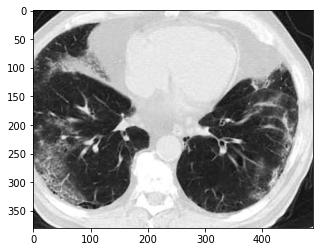

CT NonCOVID


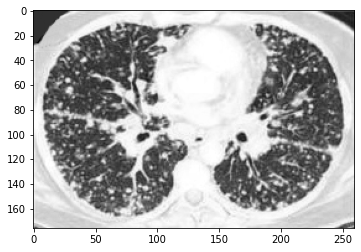

In [27]:
for i in range(len(y_train)):
  r = np.random.randint(0, 543)
  if y_train[r] == 'COVID':
    print('CT COVID')
    plt.imshow(X_train[r][:, :, 2], cmap='gray')
    plt.show()
    break

for i in range(len(y_train)):
  r = np.random.randint(0, 543)
  if y_train[i] == 'NonCOVID':
    print('CT NonCOVID')
    plt.imshow(X_train[r][:, :, 2], cmap='gray')
    plt.show()
    break



In [9]:
#X_train, y_train = load_train()
transfer = input("select transfer learning model: \n 1.ResNet50V2 2.Xception 3.DenseNet201 4.MobileNetV2 : \n")
model = estimate(X_train, y_train, transfer)

#model = load_model("Model.h5")
X_train, y_train = load_train()
y_pred = predict(X_train, model, transfer)
num = 0
for i in range(len(y_train)):
    if y_pred[i] == y_train[i]:
        num += 1
print(num/len(y_train))

select transfer learning model: 
 1.ResNet50V2 2.Xception 3.DenseNet201 4.MobileNetV2 : 
DenseNet201
74842112/74836368 [==============================] - 1s 0us/step
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
54/54 [==============================] - ETA: 0s - loss: 0.7224 - acc: 0.5211
Epoch 00001: val_loss improved from inf to 0.69845, saving model to Model.h5
54/54 [==============================] - 10s 180ms/step - loss: 0.7224 - acc: 0.5211 - val_loss: 0.6985 - val_acc: 0.5192
Epoch 2/40
54/54 [==============================] - ETA: 0s - loss: 0.6091 - acc: 0.6432
Epoch 00002: val_loss improved from 0.69845 to 0.65899, saving model to Model.h5
54/54 [==============================] - 6s 116ms/step - loss: 0.6091 - acc: 0.6432 - val_loss: 0.6590 - val_acc: 0.5769
Epoch 3/40
54/54 [==============================] - ETA: 0s - loss: 0.5779 - acc: 0.7347
Epoch 00003: val_loss improved from 0.65899 to 0.62402, saving model to Model.h5
54/54 [==

In [10]:
print(classification_report(y_train, y_pred, target_names=['COVID', 'NonCOVID']))

              precision    recall  f1-score   support

       COVID       0.90      0.97      0.93       251
    NonCOVID       0.97      0.90      0.94       292

    accuracy                           0.93       543
   macro avg       0.93      0.94      0.93       543
weighted avg       0.94      0.93      0.93       543



Confusion matrix, without normalization


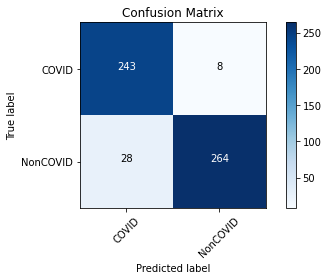

In [11]:
cm = confusion_matrix(y_train, y_pred)
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes, 
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] >thresh else "black")
        plt.tight_layout()
        plt.ylabel("True label")
        plt.xlabel("Predicted label")
plot_confusion_matrix(cm, ['COVID', 'NonCOVID'])